# Lista de Exercícios \#4
## Breno Vieira Arosa

In [1]:
import numpy as np
import pandas as pd
from scipy import stats

from sklearn.datasets import make_blobs
from functools import partial

import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec

In [2]:
plt.rcParams.update({'font.size': 14})

## Questão 1

In [3]:
def matrix2float(x, x_range=4, bias=-2):
    """
    Transform binary matrix into float.
    Floats range and bias are defined by parameters.
    Floats are linearly separated.
    
    Axis 0 should have the length of the population size.
    Axis 1 should have the length of bit precision.
    """
    precision = x.shape[1]
    
    bit_multiplier = 2**np.linspace((precision-1), 0, precision)
    x_int = np.matmul(x, bit_multiplier)
    repr_eps = x_range / (2**precision)
    x = repr_eps * x_int
    x += bias
    return x


def J(x):
    return ((x**2) - (.3 * np.cos(10 * np.pi * x)))


def F(population):
    population = matrix2float(population)
    return -J(population)

In [4]:
np.random.seed = 7
x = np.random.randint(low=0, high=2,
                      size=(6, 8),
                      dtype="uint8")
print(f"Teste de funçao auxiliar:")
print(f"x como binario:\n{x}")
print(f"x como float:\n{matrix2float(x)}")

Teste de funçao auxiliar:
x como binario:
[[1 0 0 1 0 0 1 1]
 [1 1 1 1 0 1 0 0]
 [0 0 0 0 1 0 0 1]
 [1 0 0 0 0 1 1 0]
 [0 0 0 1 0 0 1 1]
 [1 1 0 0 0 0 1 0]]
x como float:
[ 0.296875  1.8125   -1.859375  0.09375  -1.703125  1.03125 ]


In [5]:
class SGA(object):
    
    def __init__(self, binary_size, population_size,
                 fitness_func, mutation_rate):
        self.binary_size = binary_size
        self.population_size = population_size
        self.fitness_func = fitness_func
        self.mutation_rate = mutation_rate
        
        self.population = self.init_population()
    
    
    def repr_str2matrix(self, population):
        """
        Represent population as a 2D matrix.
        """
        arr = np.zeros((len(population), self.binary_size)).astype("uint8")
        for i, x in enumerate(sga.population):
            arr[i, :] = np.array(list(x)).astype("uint8")
        return arr
    
    
    def repr_matrix2str(self, population):
        """
        Represent population as a vector of binary strings.
        """
        population = population.astype(int)
        matrix2str = lambda x: "".join(map(str, x))
        return np.apply_along_axis(matrix2str, axis=1, arr=population)
    
    
    def init_population(self):
        """
        Initialize binary vectors.
        """
        x0 = np.random.randint(low=0, high=2,
                               size=(self.population_size, self.binary_size),
                               dtype="uint8")
        return x0
    
    
    def evaluate(self, population):
        return self.fitness_func(population)
    
    
    def mutate(self, rate):
        """
        Bitwise Mutation.
        
        Mutate bits with given rate.
        """
        population = self.population.copy().astype(bool)
        mutation_rand = np.random.uniform(size=(self.population_size, self.binary_size))
        
        # invert bit if random sample < mutation rate
        population[mutation_rand < rate] = ~population[mutation_rand < rate]
        return population.astype("uint8")
    
    
    def recombine(self, parents):
        """
        One-Point Crossover.
        
        The formation of pairs are randomized.
        100% children are formed from recombination (crossover rate = 1).
        The point of crossover is randomized for each pair.
        Two children are created per pair of parents.
        """
        
        # shuffle parents before form pairs
        parents = parents.copy()
        np.random.shuffle(parents)
        
        # form pairs of parents
        parents = parents.reshape(-1, 2, self.binary_size)
                
        # defines the multiplier pattern to match crossover
        cross_multiplier = np.ones((parents.shape[0], 2, self.binary_size), dtype="uint8")
        for i in range(parents.shape[0]):
            # defines the point of crossover
            # there is no crossover if point equals 0 or (binary_size-1)
            cross_idx = np.random.randint(low=1, high=(self.binary_size - 2))
            cross_multiplier[i, 0, cross_idx:self.binary_size] = 0
            cross_multiplier[i, 1, 0:cross_idx] = 0
        
        # multipliers parent pairs by crossover pattern and anti-pattern
        # developing the same number of children as parents
        children_top = (parents * cross_multiplier).sum(axis=1)
        children_bot = (parents * (~cross_multiplier.astype(bool)).astype("uint8")).sum(axis=1)
        children = np.vstack((children_top, children_bot))
        
        return children

                             
    def parent_selection(self, s=1.5):
        """
        Generational model.
        Linear Ranking Selection with Roullete Wheel probabilities.
        """
        
        fitness = self.evaluate(self.population)
        rank = stats.rankdata(fitness, "ordinal")
        u = self.population_size     
        
        p = ((2 - s) / u) + ((2 * rank * (s-1)) / (u * (u - 1)))
        p = p / p.sum()
        
        select_idx = np.random.choice(np.linspace(0, (u-1), u),
                                      size=self.population_size,
                                      replace=True, p=p).astype(int)

        return self.population[select_idx, :]

    
    def natural_selection(self, parents, children, s=1.5):
        """
        Fitness-Based Replacement.
        Linear Ranking Selection with Roullete Wheel probabilities
        """
        population = np.concatenate((parents, children))
        
        fitness = self.evaluate(population)
        rank = stats.rankdata(fitness, "ordinal")
        u = len(population)   
        
        p = ((2 - s) / u) + ((2 * rank * (s-1)) / (u * (u - 1)))
        p = p / p.sum()
        
        select_idx = np.random.choice(np.linspace(0, (u-1), u),
                                      size=self.population_size,
                                      replace=True, p=p).astype(int)
        
        return population[select_idx, :]

    
    def evolve(self):
        parents = self.parent_selection(s=1.5)
        offspring = self.recombine(parents)
        offspring = self.mutate(self.mutation_rate)
        self.population = self.natural_selection(parents, offspring, s=1.5)
        return

In [6]:
sga = SGA(binary_size=64, population_size=100,
          fitness_func=F, mutation_rate=1/64)

In [7]:
N = 200

history = np.zeros((N, sga.population_size, sga.binary_size))
for i in range(N):
    history[i, :, :] = sga.population.copy()
    sga.evolve()

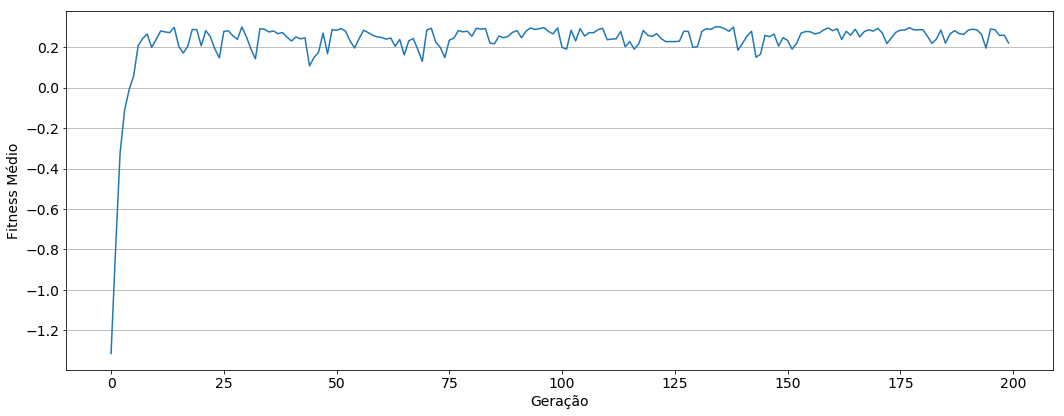

In [8]:
history_mean = np.zeros((N))
history_min = np.zeros((N))
history_max = np.zeros((N))
for i in range(N):
    fitness = sga.evaluate(history[i, :, :])
    fitness.std()
    history_mean[i] = fitness.mean()
    history_min[i] = fitness.min()
    history_max[i] = fitness.max()

plt.figure(figsize=(15, 6))

#plt.fill_between(np.linspace(0, N-1, N), history_min, history_max, alpha=.2)
plt.plot(np.linspace(0, N-1, N), history_mean)

plt.ylabel("Fitness Médio")
plt.xlabel("Geração")
plt.grid(axis="y")
plt.tight_layout()
plt.show()

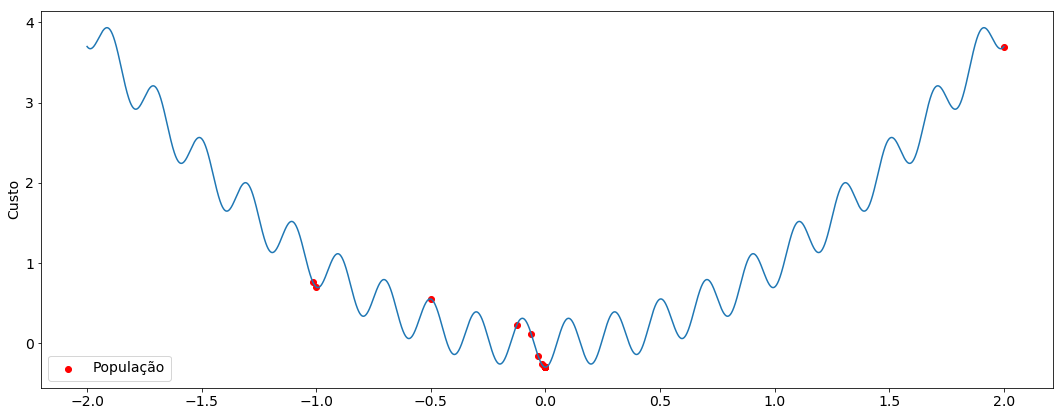

In [9]:
plt.figure(figsize=(15, 6))

population = matrix2float(sga.population)

x = np.linspace(-2, 2, 5000)
plt.plot(x, J(x))
plt.scatter(population, J(population), c="r", label="População")
plt.ylabel("Custo")
plt.legend()
plt.tight_layout()
plt.show()

## Questão 2

In [10]:
def onemax(populacao):
    return populacao.sum(axis=1)

In [11]:
# alterar parent selection
# alterar recombination (pc = .7)
# survival -> pure generational
sga = SGA(binary_size=25, population_size=100,
          fitness_func=onemax, mutation_rate=1/25)

In [12]:
N = 100

history = np.zeros((N, sga.population_size, sga.binary_size))
for i in range(N):
    history[i, :, :] = sga.population.copy()
    sga.evolve()

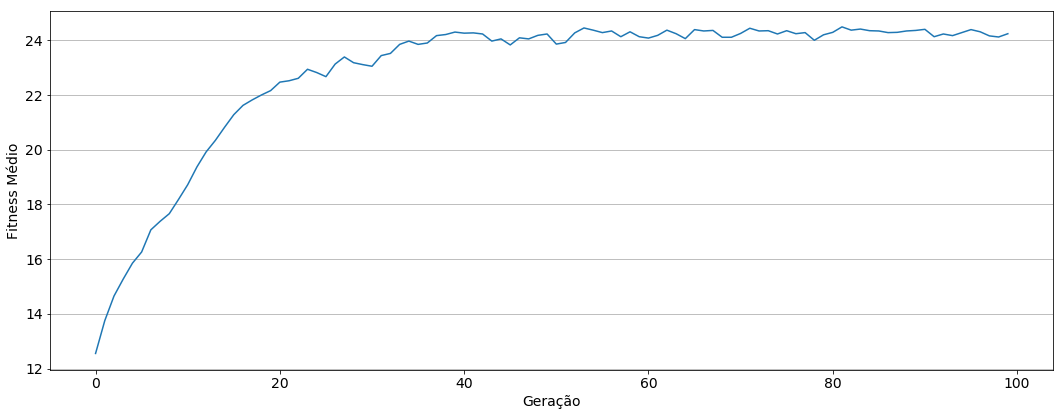

In [13]:
history_mean = np.zeros((N))
history_min = np.zeros((N))
history_max = np.zeros((N))
for i in range(N):
    fitness = sga.evaluate(history[i, :, :])
    fitness.std()
    history_mean[i] = fitness.mean()
    history_min[i] = fitness.min()
    history_max[i] = fitness.max()

plt.figure(figsize=(15, 6))

#plt.fill_between(np.linspace(0, N-1, N), history_min, history_max, alpha=.2)
plt.plot(np.linspace(0, N-1, N), history_mean)

plt.ylabel("Fitness Médio")
plt.xlabel("Geração")
plt.grid(axis="y")
plt.tight_layout()
plt.show()

In [14]:
sga.repr_matrix2str(sga.population)

array(['1111011111111111111111111', '1111111111111011110111111',
       '1111111111111111111111111', '1111111111111111111111111',
       '1111111111111111111111111', '1111111111111111111111111',
       '1111111111111011110111111', '1111111111111111111111111',
       '1111111111111111111111111', '1111111111111111111111011',
       '0111111111111111111111111', '1111111111111111111111110',
       '1111111110010111111111111', '1111111111111111111011111',
       '1111111111111111111111111', '1111111111111111111111111',
       '1111111111111111111111111', '1111111111111111111111111',
       '1111111111111111111111111', '1111111111111111111111111',
       '1111111111111011111111111', '1111111111111111111111111',
       '1111111111111111111111111', '1111111110111101111011111',
       '1111111111111111111111111', '1111111111111111111111111',
       '1111111111111101111111111', '1111111111111111111111111',
       '1011111111111111111110111', '1111111111111111111111111',
       '11111111111111111

## Questão 3

In [311]:
class ES(object):
    
    def __init__(self, individual_dimension, population_size, fitness_func):
        self.population_size = population_size
        self.individual_dimension = individual_dimension
        self.fitness_func = fitness_func
        
        self.population = self.init_population()
    
    
    def init_population(self):
        """
        Initialize binary vectors.
        """
        
        population = pd.DataFrame()
        
        #x0 = np.random.normal(loc=0, scale=1, size=(self.population_size, self.individual_dimension))
        x0 = np.random.uniform(low=-30, high=30, size=(self.population_size, self.individual_dimension))
        sigma0 = np.random.uniform(low=0, high=1, size=(self.population_size, self.individual_dimension))
        return {"x": x0, "sigma": sigma0}
    
    
    def evaluate(self, x):
        return -self.fitness_func(x)
    
    
    def mutate(self, population, tal_constant=1., sigma_eps=0.01):
        """
        Uncorrelated Mutation with n Steps.
        """
        
        n = population["x"].shape[0]
        
        tal = tal_constant * 1 / np.sqrt(2 * np.sqrt(n))
        tal_line = tal_constant * 1 / np.sqrt(2 * n)
                
        sigma = population["sigma"] * \
                    np.exp(np.random.normal(loc=0, scale=tal, size=(n, self.individual_dimension)) + \
                           np.random.normal(loc=0, scale=tal_line, size=(n, 1)))
        sigma[sigma < sigma_eps] = sigma_eps
        
        x = population["x"] + np.random.normal(loc=0, scale=sigma)
        
        return {"x": x, "sigma": sigma}
    
    
    def recombine(self, parents):
        """
        Local Recombination.
        
        Discrete is used for the object part.
        Intermediate is used for the strategy part.
        """
        
        parents = parents.copy()
        
        # shuffle parents
        n_parents = parents["x"].shape[0]
        idx_shuffled = np.random.permutation(n_parents)
        
        parents["x"] = parents["x"][idx_shuffled, :]
        parents["sigma"] = parents["sigma"][idx_shuffled, :]
        
        # form pairs of parents
        parents["x"] = parents["x"].reshape(-1, 2, self.individual_dimension)
        parents["sigma"] = parents["sigma"].reshape(-1, 2, self.individual_dimension)
        
        
        x_pattern = np.zeros(parents["x"].shape).astype(bool)
        x_pattern[:, 0, :] = np.random.randint(low=0, high=2, size=x_pattern[:, 0, :].shape).astype(bool)
        x_pattern[:, 1, :] = ~x_pattern[:, 0, :]
        x_pattern = x_pattern.astype("uint8")
        
        x = (parents["x"] * x_pattern).sum(axis=1)
        sigma = parents["sigma"].mean(axis=1)
        
        return {"x": x, "sigma": sigma}

                             
    def parent_selection(self, offspring_rate=5):
        """
        Parent Selection.
        
        Sample uniformly (2 * offspring_rate * population_size) individuals.
        This will result in the creation of a offspring population with
        offspring_rate * population_size) individuals.
        """
        
        n_parents = 2 * offspring_rate * self.population_size
        select_idx = np.random.choice(self.population_size, size=n_parents, replace=True)
        
        x = self.population["x"][select_idx, :]
        sigma = self.population["sigma"][select_idx, :]

        return {"x": x, "sigma": sigma}

    
    def natural_selection(self, population):
        """
        Comma Selection.
        """
        
        fitness = self.evaluate(population["x"])
        
        # get indices of best (population_size) individuals
        idx = np.argpartition(fitness, -self.population_size)[-self.population_size:]
        x = population["x"][idx]
        sigma = population["sigma"][idx]
        
        return {"x": x, "sigma": sigma}

    
    def evolve(self):
        parents = self.parent_selection()
        offspring = self.recombine(parents)
        offspring = self.mutate(offspring)
        self.population = self.natural_selection(offspring)
        return

In [312]:
def ackley(x):
    a = np.sqrt((x**2).mean(axis=1))
    b = (np.cos(2 * np.pi * x)).mean(axis=1)
    
    return -20 * np.exp(-.2 * a) - np.exp(b) + 20 + np.e

In [330]:
es = ES(30, 30, ackley)

In [331]:
es.population["x"].std(axis=1)

array([17.6494549 , 18.68930985, 16.89568402, 15.50257092, 15.08059871,
       19.41241152, 14.63594047, 17.79851876, 17.84119755, 16.03414191,
       14.78256195, 15.78934956, 14.73086037, 17.13582073, 17.42040801,
       17.48970179, 17.19129079, 16.60931457, 15.99548245, 17.17811885,
       16.00451707, 15.39680755, 15.93275397, 16.09765198, 14.44165425,
       17.71404189, 16.28375064, 17.89836326, 19.5467683 , 15.55753276])

In [332]:
for _ in range(1000):
    es.evolve()

In [333]:
es.population["x"].mean(axis=1)

array([ 0.00069981,  0.00597795,  0.00727908, -0.00724584,  0.0002943 ,
        0.00182091,  0.0069216 , -0.00548862, -0.00726255,  0.00929981,
        0.01343728,  0.00030809,  0.00839378,  0.00147151, -0.00081012,
       -0.00034806, -0.00070244, -0.00078614, -0.00378078,  0.00164771,
       -0.00087264,  0.00469525, -0.00602046,  0.00102589, -0.00055009,
        0.00178426,  0.00769759, -0.0084566 , -0.00276269,  0.00273616])

In [334]:
es.population["x"].std(axis=1)

array([0.02711919, 0.02595119, 0.0255462 , 0.02585784, 0.02651376,
       0.02628854, 0.0241729 , 0.02508611, 0.02519842, 0.02411352,
       0.02268714, 0.02520355, 0.02399556, 0.02622621, 0.02514622,
       0.02485499, 0.02469873, 0.02428886, 0.0239469 , 0.02403303,
       0.02370806, 0.02353022, 0.02155143, 0.02252171, 0.02286726,
       0.02276229, 0.02217478, 0.0222579 , 0.02229483, 0.02172084])

In [326]:
%load_ext line_profiler

In [329]:
%lprun -f es.mutate es.evolve()